# Hacker Earth Machine Learning Challenge 

## Problem Statement
The Bank Indessa has not done well in last 3 quarters. Their NPAs (Non Performing Assets) have reached all time high. It is starting to lose confidence of its investors. As a result, it’s stock has fallen by 20% in the previous quarter alone.
After careful analysis, it was found that the majority of NPA was contributed by loan defaulters. With the messy data collected over all the years, this bank has decided to use machine learning to figure out a way to find these defaulters and devise a plan to reduce them.
This bank uses a pool of investors to sanction their loans. For example: If any customer has applied for a loan of $20000, along with bank, the investors perform a due diligence on the requested loan application. Keep this in mind while understanding data.
In this challenge, you will help this bank by predicting the probability that a member will default.


### Solution Approach


# Importing needful libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import spearmanr
from scipy.stats import chi2_contingency
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
import catboost as cat_
import lightgbm as lgb
from sklearn.impute import SimpleImputer as Imputer
from sklearn import preprocessing
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
import re
import timeit
import random
random.seed(3)

In [2]:
dataset = pd.read_csv("datasets/dataset.csv")

In [3]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [4]:
#dataset = dataset.sample(frac = 0.1, random_state=10)

In [5]:
#pd.DataFrame(dataset).to_csv('datasets/dataset.csv', index=False)

In [6]:
dataset.head()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,batch_enrolled,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,verification_status_joint,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,loan_status
0,25386106,35000,35000,35000.0,60 months,,23.43,F,F1,Teacher,10+ years,MORTGAGE,135000.0,Source Verified,n,NaN,debt_consolidation,Debt consolidation,153xx,PA,27.14,0.0,2.0,NaN,NaN,49.0,0.0,31702.0,80.5,75.0,f,10702.29,0.00,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,74th week,0.0,0.0,346077.0,39400.0,0
1,61556649,19000,19000,18900.0,36 months,BAT1780517,9.99,B,B3,Chaplain,10+ years,RENT,79000.0,Not Verified,n,NaN,debt_consolidation,Debt consolidation,130xx,NY,29.28,0.0,2.0,NaN,NaN,22.0,0.0,20238.0,61.1,35.0,f,774.22,30.65,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,22th week,0.0,0.0,110297.0,33100.0,0
2,12619165,6600,6600,6600.0,36 months,,14.98,C,C3,NaN,10+ years,OWN,80000.0,Source Verified,n,NaN,credit_card,Credit card refinancing,277xx,NC,13.11,2.0,0.0,2.0,NaN,18.0,0.0,4323.0,21.0,42.0,f,671.56,0.00,0.0,0.0,0.0,2.0,INDIVIDUAL,NaN,39th week,1.0,0.0,27591.0,20600.0,1
3,40473262,8000,8000,8000.0,36 months,BAT4722912,6.99,A,A3,Teacher,2 years,OWN,60000.0,Verified,n,NaN,major_purchase,Major purchase,137xx,NY,13.72,0.0,0.0,NaN,NaN,26.0,0.0,27804.0,32.3,33.0,f,506.57,0.00,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,57th week,0.0,0.0,117035.0,86200.0,0
4,42563178,10000,10000,10000.0,36 months,BAT4694572,9.49,B,B2,Server,4 years,RENT,36000.0,Source Verified,n,NaN,credit_card,Credit card refinancing,900xx,CA,17.93,2.0,0.0,12.0,NaN,9.0,0.0,9244.0,24.6,15.0,w,779.70,0.00,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,52th week,0.0,381.0,33736.0,37600.0,0


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26621 entries, 0 to 26620
Data columns (total 45 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   member_id                    26621 non-null  int64  
 1   loan_amnt                    26621 non-null  int64  
 2   funded_amnt                  26621 non-null  int64  
 3   funded_amnt_inv              26621 non-null  float64
 4   term                         26621 non-null  object 
 5   batch_enrolled               22394 non-null  object 
 6   int_rate                     26621 non-null  float64
 7   grade                        26621 non-null  object 
 8   sub_grade                    26621 non-null  object 
 9   emp_title                    25105 non-null  object 
 10  emp_length                   25314 non-null  object 
 11  home_ownership               26621 non-null  object 
 12  annual_inc                   26621 non-null  float64
 13  verification_sta

In [8]:
dataset.isnull().sum()

member_id                          0
loan_amnt                          0
funded_amnt                        0
funded_amnt_inv                    0
term                               0
batch_enrolled                  4227
int_rate                           0
grade                              0
sub_grade                          0
emp_title                       1516
emp_length                      1307
home_ownership                     0
annual_inc                         0
verification_status                0
pymnt_plan                         0
desc                           22783
purpose                            0
title                              3
zip_code                           0
addr_state                         0
dti                                0
delinq_2yrs                        0
inq_last_6mths                     0
mths_since_last_delinq         13503
mths_since_last_record         22586
open_acc                           0
pub_rec                            0
r

In [9]:
dataset.columns

Index(['member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term',
       'batch_enrolled', 'int_rate', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'pymnt_plan', 'desc', 'purpose', 'title', 'zip_code', 'addr_state',
       'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'application_type', 'verification_status_joint', 'last_week_pay',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'loan_status'],
      dtype='object')

In [10]:
y = dataset.loan_status.values
y.shape

(26621,)

## VISUALISATION

<AxesSubplot:xlabel='loan_status', ylabel='count'>

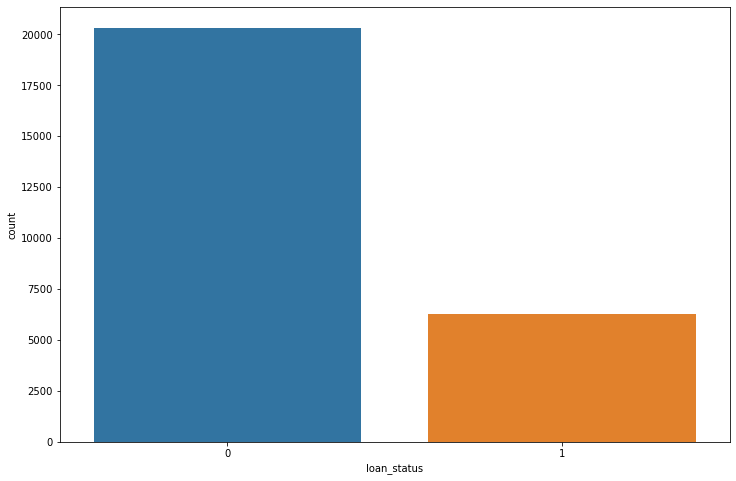

In [11]:
plt.figure(figsize = [12,8])
sns.countplot(x = 'loan_status', data = dataset)

<AxesSubplot:xlabel='purpose', ylabel='count'>

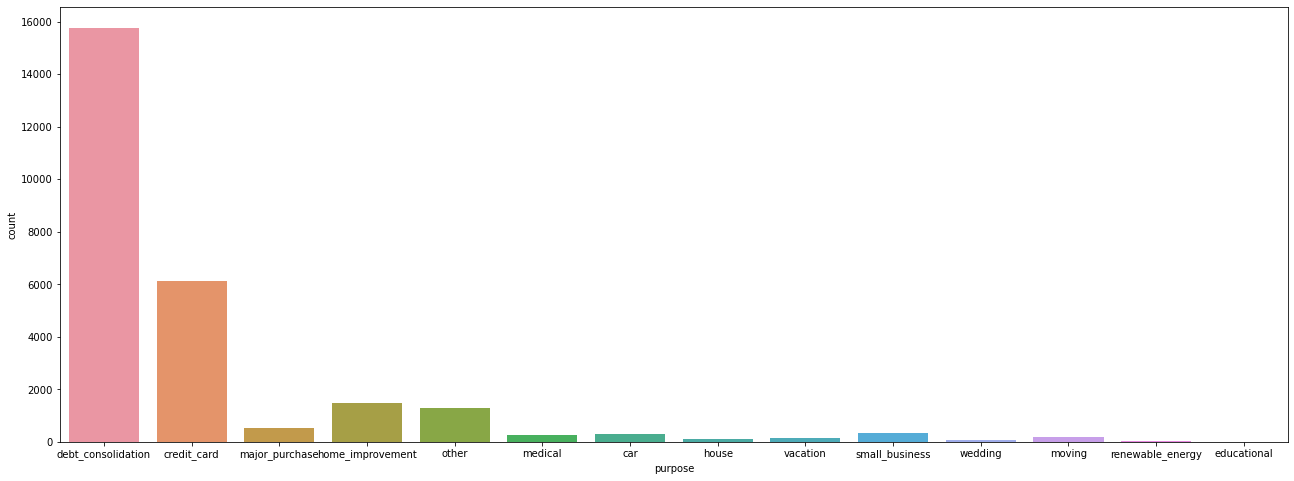

In [12]:
plt.figure(figsize=(22,8))
sns.countplot(x = 'purpose', data = dataset)

In [13]:
#dataset['home_ownership'].values_count()

<AxesSubplot:xlabel='home_ownership', ylabel='count'>

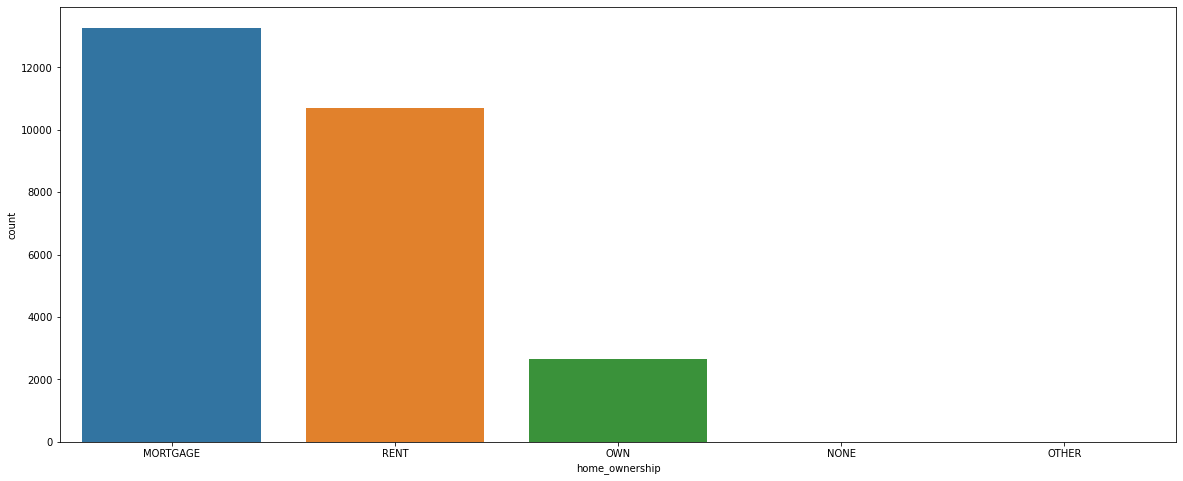

In [14]:
plt.figure(figsize=(20,8))
sns.countplot(x = 'home_ownership', data = dataset)

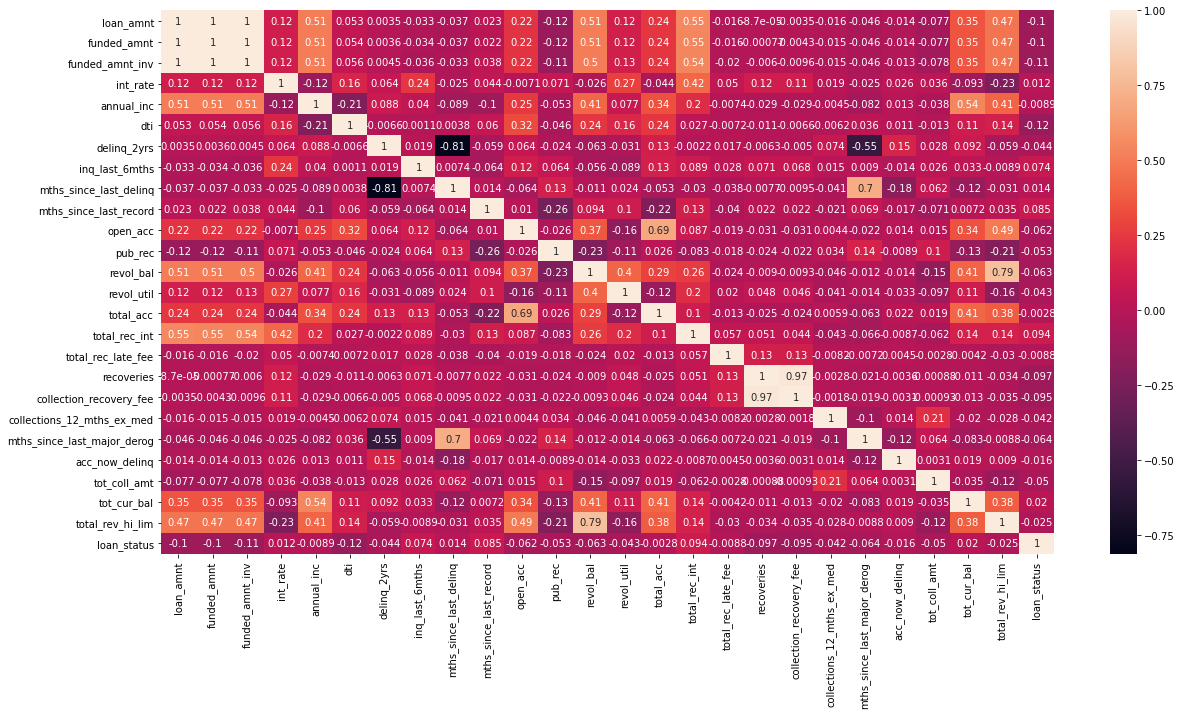

In [15]:
plt.figure(figsize=(20,10))
#cor = dataset.
cor = dataset.drop('member_id', axis=1).corr(method = 'spearman')
fig = sns.heatmap(cor, annot=True)
plt.show(fig)

In [16]:
#correlation, pval = spearmanr(dataset.drop("member_id",axis=1))
#print(f'correlation={correlation:.6f},p-value={pval:.6f}')
#from scipy.stats import rankdata
#sns.jointplot(x=dataset['emp_length'], y=dataset['loan_amnt'])

In [17]:
print(dataset.drop("member_id", axis=1).corr(method='spearman'))

                             loan_amnt  funded_amnt  funded_amnt_inv  \
loan_amnt                     1.000000     0.999438         0.996628   
funded_amnt                   0.999438     1.000000         0.997366   
funded_amnt_inv               0.996628     0.997366         1.000000   
int_rate                      0.119663     0.119912         0.119889   
annual_inc                    0.510594     0.510110         0.508614   
dti                           0.053009     0.053838         0.056468   
delinq_2yrs                   0.003515     0.003614         0.004519   
inq_last_6mths               -0.033394    -0.033565        -0.036465   
mths_since_last_delinq       -0.036907    -0.036648        -0.033242   
mths_since_last_record        0.022529     0.022305         0.038021   
open_acc                      0.221139     0.221522         0.222293   
pub_rec                      -0.116194    -0.115775        -0.113660   
revol_bal                     0.505228     0.505030         0.50

## DATA CLEANING 

## Droping some unwanted dependent variables

In [18]:
### columns undropped from original data ['grade','addr_state', 'pymnt_plan','verification_status','delinq_2yrs',]

In [19]:
drop_col = ['member_id','funded_amnt', 'funded_amnt_inv', 'batch_enrolled','sub_grade', 'mths_since_last_delinq', 'mths_since_last_record', 'mths_since_last_major_derog','emp_title', 'desc','title','zip_code','verification_status_joint','last_week_pay','loan_status','recoveries']

In [20]:
dataset_1 = dataset.drop(['member_id','funded_amnt', 'funded_amnt_inv', 'batch_enrolled','mths_since_last_delinq', 'mths_since_last_record', 'mths_since_last_major_derog','sub_grade', 'emp_title', 'desc','title','zip_code','verification_status_joint','last_week_pay','loan_status','recoveries'], axis=1)

In [21]:
dataset_1.shape

(26621, 29)

In [22]:
dataset_1.emp_length.unique()

array(['10+ years', '2 years', '4 years', '5 years', '8 years', '6 years',
       '3 years', '7 years', nan, '< 1 year', '1 year', '9 years'],
      dtype=object)

In [23]:
columns  = dataset_1.columns
columns

Index(['loan_amnt', 'term', 'int_rate', 'grade', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'pymnt_plan',
       'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'total_rec_int', 'total_rec_late_fee',
       'collection_recovery_fee', 'collections_12_mths_ex_med',
       'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'total_rev_hi_lim'],
      dtype='object')

In [24]:
dataset_1.application_type.unique()

array(['INDIVIDUAL', 'JOINT'], dtype=object)

### Converting objects variables to integers

In [25]:
dataset_1['emp_length'] = dataset_1['emp_length'].replace({np.nan:0, '< 1 year':1, '1 year':2, '2 years':3, '3 years':4, '4 years':5, '5 years':6, '6 years':7, '7 years':8, '8 years':9, '9 years':10, '10+ years':11})

dataset_1['term'] = dataset_1['term'].replace({'36 months':36, '60 months':60})

dataset_1['home_ownership']=dataset_1['home_ownership'].replace({'OWN':6, 'MORTGAGE':5, 'RENT':4, 'OTHER':3, 'NONE':2, 'ANY':1})

dataset_1['purpose'] = dataset_1['purpose'].replace({'small_business':1,'debt_consolidation':2, 'home_improvement':3, 'credit_card':4,'major_purchase':5,  
                                                     'vacation':6, 'car':7, 'moving':8,'medical':9, 'wedding':10, 'renewable_energy':11, 'house':12, 'educational':13,'other':14,})
dataset_1['application_type'] = dataset_1['application_type'].replace({'INDIVIDUAL':1, 'JOINT':2})

dataset_1['verification_status'] = dataset_1['verification_status'].replace({'Source Verified':1, 'Not Verified':0, 'Verified':1})

dataset_1['grade'] = dataset_1['grade'].replace({'E':2, 'B':5, 'A':6, 'D':3, 'C':4, 'F':1, 'G':0})

dataset_1['pymnt_plan'] = dataset_1['pymnt_plan'].replace({'n':0, 'y':1})

dataset_1['initial_list_status'] = dataset_1['initial_list_status'].replace({'f':1, 'w':0})

dataset_1['addr_state'] = dataset_1['addr_state'].replace({'ND':0, 'NE':0,'IA':0,'NV':0,'FL':0,'HI':0,'AL':0,'NY':0,'NM':1,'VA':1,'OK':2,'TN':2,'MO':2,'LA':2,'MD':2,'NC':2,'UT':3,
                 'KY':3,'AZ':3,'NJ':3,'AR':4,'MI':4,'PA':4,'OH':4,'MN':4,'CA':4,'RI':5,'MA':5,'DE':5,'SD':5,'IN':5,'GA':6,'WA':6,'OR':6,
                 'WI':7,'MT':7,'IL':8,'CT':8,'KS':9,'SC':9,'CO':9,'VT':9,'AK':9,'MS':9,'TX':9,'WV':10,'NH':10,'WY':10,'DC':10,'ME':10,'ID':10})

    

In [26]:
dataset_1.addr_state.unique()

array([ 4,  0,  2,  9,  3,  6,  8, 10,  1,  5,  7], dtype=int64)

## New features

In [27]:
dataset_1['term'] = dataset_1['term'].apply(lambda x: float(x))

In [28]:
value = -9999
def helping_features(value):
    i = ((dataset_1['int_rate'])/100)/12
    d = 1 - (1/(1+i)**dataset_1['term'])
    dataset_1['Monthly_supposed_payment'] = (dataset_1['loan_amnt']*i)/d
    dataset_1['Total_refund'] = dataset_1['Monthly_supposed_payment']*dataset_1['term']
    #dataset['Interest_amnt'] = dataset['Total_refund'] - dataset['loan_amnt']
    dataset_1['Monthly_income'] = dataset_1['annual_inc'].apply(lambda x : x/12 if x >=0 else -9999)

In [29]:
helping_features(-9999)
dataset_1.head()

,loan_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_int,total_rec_late_fee,collection_recovery_fee,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,Monthly_supposed_payment,Total_refund,Monthly_income
0,35000,60.0,23.43,1,11,5,135000.0,1,0,2,4,27.14,0.0,2.0,49.0,0.0,31702.0,80.5,75.0,1,10702.29,0.00,0.0,0.0,1,0.0,0.0,346077.0,39400.0,995.332472,59719.948316,11250.000000
1,19000,36.0,9.99,5,11,4,79000.0,0,0,2,0,29.28,0.0,2.0,22.0,0.0,20238.0,61.1,35.0,1,774.22,30.65,0.0,0.0,1,0.0,0.0,110297.0,33100.0,612.987357,22067.544839,6583.333333
2,6600,36.0,14.98,4,11,6,80000.0,1,0,4,2,13.11,2.0,0.0,18.0,0.0,4323.0,21.0,42.0,1,671.56,0.00,0.0,0.0,1,1.0,0.0,27591.0,20600.0,228.726532,8234.155168,6666.666667
3,8000,36.0,6.99,6,3,6,60000.0,1,0,5,0,13.72,0.0,0.0,26.0,0.0,27804.0,32.3,33.0,1,506.57,0.00,0.0,0.0,1,0.0,0.0,117035.0,86200.0,246.980199,8891.287175,5000.000000
4,10000,36.0,9.49,5,5,4,36000.0,1,0,4,4,17.93,2.0,0.0,9.0,0.0,9244.0,24.6,15.0,0,779.70,0.00,0.0,0.0,1,0.0,381.0,33736.0,37600.0,320.282754,11530.179142,3000.000000


In [30]:
dataset_1.collections_12_mths_ex_med.unique()

array([ 0.,  1.,  2., nan,  4.,  3.,  5.])

## Filling missing values

In [31]:
dataset_1.isnull().sum()

loan_amnt                        0
term                             0
int_rate                         0
grade                            0
emp_length                       0
home_ownership                   0
annual_inc                       0
verification_status              0
pymnt_plan                       0
purpose                          0
addr_state                       0
dti                              0
delinq_2yrs                      0
inq_last_6mths                   0
open_acc                         0
pub_rec                          0
revol_bal                        0
revol_util                      15
total_acc                        0
initial_list_status              0
total_rec_int                    0
total_rec_late_fee               0
collection_recovery_fee          0
collections_12_mths_ex_med       4
application_type                 0
acc_now_delinq                   0
tot_coll_amt                  2138
tot_cur_bal                   2138
total_rev_hi_lim    

In [32]:
def fill_nulls(value):
    cols_fill = ['collections_12_mths_ex_med','revol_util', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']
    
    if value == -9999:
        for col in cols_fill:
            dataset_1.loc[dataset_1[col].isnull(), col] = -9999
    else : 
        for col in cols_fill:
            dataset_1.loc[dataset_1[col].isnull(), col] = dataset_1[col].mean()

In [33]:
fill_nulls(-9999)

In [34]:
dataset_1.columns

Index(['loan_amnt', 'term', 'int_rate', 'grade', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'pymnt_plan',
       'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'total_rec_int', 'total_rec_late_fee',
       'collection_recovery_fee', 'collections_12_mths_ex_med',
       'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'total_rev_hi_lim', 'Monthly_supposed_payment', 'Total_refund',
       'Monthly_income'],
      dtype='object')

In [35]:
dataset_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26621 entries, 0 to 26620
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   loan_amnt                   26621 non-null  int64  
 1   term                        26621 non-null  float64
 2   int_rate                    26621 non-null  float64
 3   grade                       26621 non-null  int64  
 4   emp_length                  26621 non-null  int64  
 5   home_ownership              26621 non-null  int64  
 6   annual_inc                  26621 non-null  float64
 7   verification_status         26621 non-null  int64  
 8   pymnt_plan                  26621 non-null  int64  
 9   purpose                     26621 non-null  int64  
 10  addr_state                  26621 non-null  int64  
 11  dti                         26621 non-null  float64
 12  delinq_2yrs                 26621 non-null  float64
 13  inq_last_6mths              266

## SCALING THE DATASET 

In [36]:
columns = dataset_1.columns
columns

Index(['loan_amnt', 'term', 'int_rate', 'grade', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'pymnt_plan',
       'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'total_rec_int', 'total_rec_late_fee',
       'collection_recovery_fee', 'collections_12_mths_ex_med',
       'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'total_rev_hi_lim', 'Monthly_supposed_payment', 'Total_refund',
       'Monthly_income'],
      dtype='object')

In [37]:
# Use 3 features
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer
from sklearn.feature_selection import SelectKBest, f_classif
df = SelectKBest(f_classif, k=3)
df1 = StandardScaler()
data_scale = df1.fit_transform(dataset_1) 
data = pd.DataFrame(data_scale, columns=columns)
data.head()

,loan_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_int,total_rec_late_fee,collection_recovery_fee,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,Monthly_supposed_payment,Total_refund,Monthly_income
0,2.400992,1.521983,2.339654,-2.456020,1.123245,0.471572,0.836856,0.651534,0.0,-0.498236,-0.036645,1.092580,-0.360911,1.322423,7.144052,-0.314012,0.651221,0.129825,4.222159,0.972322,4.186758,-0.096581,-0.079717,0.012138,-0.025278,-0.070320,0.181932,1.390015,0.314391,2.295524,3.346880,0.836856
1,0.503562,-0.657038,-0.738189,0.602702,1.123245,-1.088284,0.053102,-1.534839,0.0,-0.498236,-1.369800,1.350092,-0.360911,1.322423,2.002063,-0.314012,0.145303,0.048922,0.830719,0.972322,-0.462838,7.309022,-0.079717,0.012138,-0.025278,-0.070320,0.181932,-0.120756,0.129189,0.725300,0.231720,0.053102
2,-0.966947,-0.657038,0.404552,-0.161979,1.123245,2.031429,0.067097,0.651534,0.0,0.208719,-0.703223,-0.595689,1.930758,-0.694837,1.240286,-0.314012,-0.557042,-0.118304,1.424221,0.972322,-0.510916,-0.096581,-0.079717,0.012138,-0.025278,11.703155,0.181932,-0.650699,-0.238276,-0.852792,-0.912781,0.067097
3,-0.800922,-0.657038,-1.425208,1.367382,-0.935849,2.031429,-0.212815,0.651534,0.0,0.562197,-1.369800,-0.522286,-0.360911,-0.694837,2.763839,-0.314012,0.479198,-0.071180,0.661147,0.972322,-0.588186,-0.096581,-0.079717,0.012138,-0.025278,-0.070320,0.181932,-0.077582,1.690181,-0.777827,-0.858413,-0.212815
4,-0.563743,-0.657038,-0.852693,0.602702,-0.421075,-1.088284,-0.548710,0.651534,0.0,0.208719,-0.036645,-0.015685,1.930758,-0.694837,-0.473710,-0.314012,-0.339873,-0.103291,-0.865001,-1.028466,-0.460271,-0.096581,-0.079717,0.012138,-0.025278,-0.070320,0.297161,-0.611325,0.261477,-0.476786,-0.640086,-0.548710


### Spliting the test and trian data

In [38]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(data,y, test_size=0.2, random_state=0)

In [39]:
X_train.shape

(21296, 32)

In [40]:
X_test.shape

(5325, 32)

In [41]:
y_train.shape

(21296,)

In [42]:
y_test.shape

(5325,)

# Training the Data - Model

In [43]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(max_iter=1000)
classifier = classifier.fit(X_train, y_train)

In [44]:
y_pred = classifier.predict(X_test)

In [45]:
y_pred_prob = classifier.predict_proba(X_test)[:,1]
y_pred_prob

array([0.86036537, 0.06035422, 0.40631351, ..., 0.14483532, 0.0817448 ,
       0.13380291])

In [46]:
from sklearn import metrics
accuracy = metrics.accuracy_score(y_test, y_pred)
accuracy

0.816150234741784

In [47]:
classifier.coef_

array([[-1.33395737e+00, -3.57166474e-01,  1.98969397e+00,
         1.87072332e+00,  2.51891730e-02, -2.21248092e-03,
        -3.66724504e-02, -7.04218718e-02,  0.00000000e+00,
        -2.68556952e-02,  2.65591603e-02, -2.46517565e-01,
        -1.22272425e-01,  5.98420067e-02, -2.31785133e-01,
        -1.25841207e-01, -1.65401777e-01,  2.88494675e-03,
         3.08429082e-01,  3.11224015e-01, -1.52405124e-01,
        -9.49873061e-02, -9.38822197e+00,  8.31634425e-03,
        -1.69151640e-01, -3.34879693e-02, -9.96428742e-01,
         1.69012846e-01,  1.31806444e-01,  4.27144407e-01,
         9.75399920e-01, -3.66724504e-02]])

In [48]:
### Manipulating the parameters - second model

In [49]:
model = LogisticRegression(max_iter=1000)
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)


In [50]:
y_pred_1 = grid_result.predict(X_test)

In [51]:
accuracy_2 = metrics.accuracy_score(y_test, y_pred_1)
accuracy_2

0.8204694835680751

In [52]:
classifier.coef_

array([[-1.33395737e+00, -3.57166474e-01,  1.98969397e+00,
         1.87072332e+00,  2.51891730e-02, -2.21248092e-03,
        -3.66724504e-02, -7.04218718e-02,  0.00000000e+00,
        -2.68556952e-02,  2.65591603e-02, -2.46517565e-01,
        -1.22272425e-01,  5.98420067e-02, -2.31785133e-01,
        -1.25841207e-01, -1.65401777e-01,  2.88494675e-03,
         3.08429082e-01,  3.11224015e-01, -1.52405124e-01,
        -9.49873061e-02, -9.38822197e+00,  8.31634425e-03,
        -1.69151640e-01, -3.34879693e-02, -9.96428742e-01,
         1.69012846e-01,  1.31806444e-01,  4.27144407e-01,
         9.75399920e-01, -3.66724504e-02]])

In [53]:
metrics.confusion_matrix(y_test, y_pred_1)

array([[3924,  138],
       [ 818,  445]], dtype=int64)

### XGBOOST MODEL

In [54]:
# xgboost for regression
start = timeit.default_timer()
from xgboost import XGBClassifier
model_xgb = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='mlogloss')
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)
y_pred_prob = model_xgb.predict_proba(X_test.values)[:,1]
stop = timeit.default_timer()
print(stop - start)

4.775206199999985


In [55]:
y_pred_prob = model_xgb.predict_proba(X_test.values)#[:,1]
pd.DataFrame(y_pred_prob).head()

,0,1
0,0.019233,0.980767
1,0.991328,0.008672
2,0.327750,0.672250
3,0.899577,0.100423
4,0.805365,0.194635


In [62]:
y_download = model_xgb.predict_proba(X_test.values)[:,1]
pd.DataFrame(y_download).to_csv('datasets/y_pred_prob.csv')

In [56]:
accuracy_xgb = metrics.accuracy_score(y_test, y_pred_xgb)
print(accuracy_xgb)
'{:.2f}'.format(accuracy_xgb)

0.8413145539906103


'0.84'

# Save Our Model
* Serialization
* Pickle
* Joblib
* numpy/json/ray

In [57]:
# Using Joblib
import joblib

model_file = open("models/classifier_model.pkl","wb")
joblib.dump(classifier,model_file)
model_file.close()

model_file = open("models/classifier_model_2.pkl","wb")
joblib.dump(grid_result,model_file)
model_file.close()

Prediction = pd.DataFrame({
    'member_id' : member_id,
    'loan_status' : stack_result_prob
})
Prediction = Prediction[['member_id','loan_status']]

Prediction.to_csv('datasets/Prdeiction.csv', index = False)

# Creating the summary table

In [58]:
feature_name = ['loan_amnt', 'term', 'int_rate', 'grade', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'pymnt_plan',
       'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'collections_12_mths_ex_med',
       'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'total_rev_hi_lim', 'Monthly_supposed_payment', 'Total_refund',
       'Monthly_income']

In [59]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(classifier.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', classifier.intercept_[0]]
summary_table = summary_table.sort_index()
summary_table

ValueError: Length of values (32) does not match length of index (33)

In [ ]:
inputs_train = X_train
X_train.head()

In [ ]:
inputs_test = X_test
X_test.head()

In [ ]:
#y_hat_test = classifier.predict(inputs_test)
#y_hat_test

In [ ]:
y_pred_prob

In [ ]:
y_hat_test_proba = y_pred_prob
y_hat_test_proba

In [ ]:
y_test = pd.DataFrame(y_test)
y_test.tail()

In [ ]:
loan_data_targets_test = y_test
loan_data_targets_test.head()

In [ ]:
df_actual_predicted_probs = pd.concat([loan_data_targets_test, pd.DataFrame(y_hat_test_proba)], axis = 1)
# Concatenates two dataframes.

In [ ]:
df_actual_predicted_probs.columns = ['loan_data_targets_test', 'y_hat_test_proba']

In [ ]:
df_actual_predicted_probs.head()

## Accuracy and Area under the Curve

In [ ]:
tr = 0.5
# We create a new column with an indicator,
# where every observation that has predicted probability greater than the threshold has a value of 1,
# and every observation that has predicted probability lower than the threshold has a value of 0.
df_actual_predicted_probs['y_hat_test'] = np.where(df_actual_predicted_probs['y_hat_test_proba'] > tr, 1, 0)

In [ ]:
pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'], rownames = ['Actual'], colnames = ['Predicted'])
# Creates a cross-table where the actual values are displayed by rows and the predicted values by columns.
# This table is known as a Confusion Matrix.

In [ ]:
pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]
# Here we divide each value of the table by the total number of observations,
# thus getting percentages, or, rates.

In [ ]:
(pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[0, 0] + (pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[1, 1]
# Here we calculate Accuracy of the model, which is the sum of the diagonal rates.

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
roc_curve(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test_proba'])
# Returns the Receiver Operating Characteristic (ROC) Curve from a set of actual values and their predicted probabilities.
# As a result, we get three arrays: the false positive rates, the true positive rates, and the thresholds.

In [ ]:
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test_proba'])
# Here we store each of the three arrays in a separate variable. 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
plt.plot(fpr, tpr)
# We plot the false positive rate along the x-axis and the true positive rate along the y-axis,
# thus plotting the ROC curve.
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
# We plot a seconary diagonal line, with dashed line style and black color.
plt.xlabel('False positive rate')
# We name the x-axis "False positive rate".
plt.ylabel('True positive rate')
# We name the x-axis "True positive rate".
plt.title('ROC curve')
# We name the graph "ROC curve".

# Accuracy

In [ ]:
AUROC = roc_auc_score(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test_proba'])
# Calculates the Area Under the Receiver Operating Characteristic Curve (AUROC)
# from a set of actual values and their predicted probabilities.
'{:.2f}'.format(AUROC)

## Gini and Kolmogorov-Smirnov

In [ ]:
df_actual_predicted_probs = df_actual_predicted_probs.sort_values('y_hat_test_proba')
# Sorts a dataframe by the values of a specific column.

In [ ]:
df_actual_predicted_probs.head()

In [ ]:
df_actual_predicted_probs.tail()

In [ ]:
df_actual_predicted_probs = df_actual_predicted_probs.reset_index()
# We reset the index of a dataframe and overwrite it.

In [ ]:
df_actual_predicted_probs.head()

In [ ]:
df_actual_predicted_probs['Cumulative N Population'] = df_actual_predicted_probs.index + 1
# We calculate the cumulative number of all observations.
# We use the new index for that. Since indexing in ython starts from 0, we add 1 to each index.
df_actual_predicted_probs['Cumulative N Good'] = df_actual_predicted_probs['loan_data_targets_test'].cumsum()
# We calculate cumulative number of 'good', which is the cumulative sum of the column with actual observations.
df_actual_predicted_probs['Cumulative N Bad'] = df_actual_predicted_probs['Cumulative N Population'] - df_actual_predicted_probs['loan_data_targets_test'].cumsum()
# We calculate cumulative number of 'bad', which is
# the difference between the cumulative number of all observations and cumulative number of 'good' for each row.

In [ ]:
df_actual_predicted_probs['Cumulative Perc Population'] = df_actual_predicted_probs['Cumulative N Population'] / (df_actual_predicted_probs.shape[0])
# We calculate the cumulative percentage of all observations.
df_actual_predicted_probs['Cumulative Perc Good'] = df_actual_predicted_probs['Cumulative N Good'] / df_actual_predicted_probs['loan_data_targets_test'].sum()
# We calculate cumulative percentage of 'good'.
df_actual_predicted_probs['Cumulative Perc Bad'] = df_actual_predicted_probs['Cumulative N Bad'] / (df_actual_predicted_probs.shape[0] - df_actual_predicted_probs['loan_data_targets_test'].sum())
# We calculate the cumulative percentage of 'bad'.

In [ ]:
df_actual_predicted_probs.head()

In [ ]:
# Plot Gini
plt.plot(df_actual_predicted_probs['Cumulative Perc Population'], df_actual_predicted_probs['Cumulative Perc Bad'])
# We plot the cumulative percentage of all along the x-axis and the cumulative percentage 'good' along the y-axis,
# thus plotting the Gini curve.
plt.plot(df_actual_predicted_probs['Cumulative Perc Population'], df_actual_predicted_probs['Cumulative Perc Population'], linestyle = '--', color = 'k')
# We plot a seconary diagonal line, with dashed line style and black color.
plt.xlabel('Cumulative % Population')
# We name the x-axis "Cumulative % Population".
plt.ylabel('Cumulative % Bad')
# We name the y-axis "Cumulative % Bad".
plt.title('Gini')
# We name the graph "Gini".

In [ ]:
Gini = AUROC * 2 - 1
# Here we calculate Gini from AUROC.
Gini

In [ ]:
# Plot KS
plt.plot(df_actual_predicted_probs['y_hat_test_proba'], df_actual_predicted_probs['Cumulative Perc Bad'], color = 'r')
# We plot the predicted (estimated) probabilities along the x-axis and the cumulative percentage 'bad' along the y-axis,
# colored in red.
plt.plot(df_actual_predicted_probs['y_hat_test_proba'], df_actual_predicted_probs['Cumulative Perc Good'], color = 'b')
# We plot the predicted (estimated) probabilities along the x-axis and the cumulative percentage 'good' along the y-axis,
# colored in red.
plt.xlabel('Estimated Probability for being Good')
# We name the x-axis "Estimated Probability for being Good".
plt.ylabel('Cumulative %')
# We name the y-axis "Cumulative %".
plt.title('Kolmogorov-Smirnov')
# We name the graph "Kolmogorov-Smirnov".

In [ ]:
KS = max(df_actual_predicted_probs['Cumulative Perc Bad'] - df_actual_predicted_probs['Cumulative Perc Good'])
# We calculate KS from the data. It is the maximum of the difference between the cumulative percentage of 'bad'
# and the cumulative percentage of 'good'.
KS

# Creating a Scorecard

In [ ]:
summary_table

In [ ]:
min_score = 300
max_score = 850

In [ ]:
df_scorecard = summary_table

In [ ]:
df_scorecard.groupby('Feature name')['Coefficients'].min()
# Groups the data by the values of the 'feature name' column.
# Aggregates the data in the 'Coefficients' column, calculating their minimum.

In [ ]:
min_sum_coef_1 = df_scorecard['Coefficients'].min()
# Up to the 'min()' method everything is the same as in te line above.
# Then, we aggregate further and sum all the minimum values.
min_sum_coef = -1.5386183729406917

In [ ]:
max_sum_coef_1 = df_scorecard['Coefficients'].max()
# Up to the 'min()' method everything is the same as in te line above.
# Then, we aggregate further and sum all the minimum values.
max_sum_coef = 5.590270189646491

In [ ]:
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * (max_score - min_score) / (max_sum_coef - min_sum_coef)
# We multiply the value of the 'Coefficients' column by the ration of the differences between
# maximum score and minimum score and maximum sum of coefficients and minimum sum of cefficients.
df_scorecard

In [ ]:
df_scorecard['Score - Calculation'][0] = ((df_scorecard['Coefficients'][0] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score
# We divide the difference of the value of the 'Coefficients' column and the minimum sum of coefficients by
# the difference of the maximum sum of coefficients and the minimum sum of coefficients.
# Then, we multiply that by the difference between the maximum score and the minimum score.
# Then, we add minimum score. 
df_scorecard

In [ ]:
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()
# We round the values of the 'Score - Calculation' column.
df_scorecard

In [ ]:
df_scorecard['Score - Preliminary'] = abs(df_scorecard['Score - Preliminary'])
df_scorecard

In [ ]:
X_test_intercept = X_test.insert(0, 'Intercept', 1)
# We insert a column in the dataframe, with an index of 0, that is, in the beginning of the dataframe.
# The name of that column is 'Intercept', and its values are 1s.
X_test.head()

In [ ]:
X_test_intercept.shape

In [ ]:
X_test.shape

In [ ]:
scorecard_scores = df_scorecard['Score - Final']

In [ ]:
scorecard_scores.shape

In [ ]:
scorecard_scores = scorecard_scores.values.reshape(34, 1)
scorecard_scores.shape

In [ ]:
y_scores = X_test_intercept.dot(scorecard_scores)
# Here we multiply the values of each row of the dataframe by the values of each column of the variable,
# which is an argument of the 'dot' method, and sum them. It's essentially the sum of the products.
y_scores.head()

### From Credit Score to PD

In [ ]:
sum_coef_from_score = ((y_scores - min_score) / (max_score - min_score))
# We divide the difference between the scores and the minimum score by
# the difference between the maximum score and the minimum score.
# Then, we multiply that by the difference between the maximum sum of coefficients and the minimum sum of coefficients.
# Then, we add the minimum sum of coefficients.
sum_coef_from_score

In [ ]:
y_hat_proba_from_score = np.exp(sum_coef_from_score) / (np.exp(sum_coef_from_score) + 1)
# Here we divide an exponent raised to sum of coefficients from score by
# an exponent raised to sum of coefficients from score plus one.
y_hat_proba_from_score.head()

In [ ]:
y_hat_test_proba[0: 5]